In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
%matplotlib inline
import camb
from camb import model, initialpower
from colossus.cosmology import cosmology  
from colossus.halo import mass_so
from colossus.lss import mass_function
from colossus.lss import bias

In [2]:
params = cosmology.cosmologies['planck15']
params['Om0'] = 0.281
params['Ob0'] = 0.0462
params['Ode0'] = 0.719
params['H0'] = 71
cosmo = cosmology.setCosmology('planck15',params)


Omega_m = 0.281
Omega_b = 0.0462
Omega_lambda = 0.719
h = 0.71
alpha = 0.17
beta = -0.55
v_c0 = 37.1535  #km/s
v_c1 = 24547.08916 #km/s

In [3]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=71, ombh2=0.02328942, omch2=0.11836268, mnu=0, omk=0, tau=0.06)

class: <CAMBparams>
 WantCls = True
 WantTransfer = False
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = False
   accurate_massive_neutrinos = False
   kmax = 0.9
   k_per_logint = 0
   PK_num_redshifts = 1
   PK_redshifts = [0.0]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2500
 max_l_tensor = 600
 max_eta_k = 5000.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.02328942
 omch2 = 0.11836268
 omk = 0.0
 omnuh2 = 0.0
 H0 = 71.0
 TCMB = 2.7255
 YHe = 0.2457852828457311
 num_nu_massless = 3.046
 num_nu_massive = 0
 nu_mass_eigenstates = 0
 share_delta_neff = False
 nu_mass_degeneracies = []
 nu_mass_fractions = []
 nu_mass_numbers = []
 InitPower: <InitialPowerLaw>
   tensor_parameterization = tensor_param_rpivot
   ns = 0.96
   nrun = 0.0
   nrunrun = 0.0
   nt = -0.0
   ntrun 

In [4]:
def M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c):
    v_c=96.6*((Delta_c*Omega_m*(h**2)/24.4)**(1/6))*(((1+z)/3.3)**(1/2))*((M/10**11)**(1/3))
    f_HI=(Omega_b/Omega_m)*(0.75) # (1-Y)*Omega_b/Omega_m
    return alpha*f_HI*M*((M*h/1e11)**beta)*np.exp(-(v_c0/v_c)**3)*np.exp(-(v_c/v_c1)**3)
np.vectorize(M_HI)

## Utilizando las funciones de colossus

In [5]:
# Se va a intentar despejar n de ahí. Se tiene que n=(dn/dlnM) (unidades de (Mpc/h)**(-3))
def n(Masa, z):
    n = mass_function.massFunction(Masa, z, mdef = 'fof', model = 'sheth99', q_out = 'dndlnM')
    return n

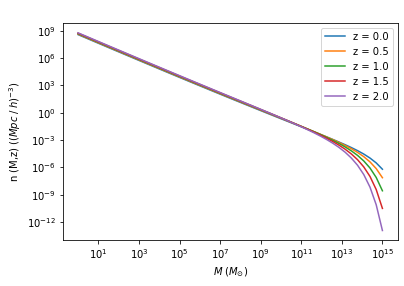

In [6]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M \; (M_{\odot})$')
plt.ylabel(r'n (M,z) (${(Mpc \; / \; h)}^{-3}$)')

title_obj = plt.title('n(M,z) colossus')            
plt.setp(title_obj, color='white') 
redshift = np.linspace(0,2,5)
Masa = np.logspace(0,15)
for z in redshift:
    plt.plot(Masa,n(Masa, z),label='z = {:.1f}'.format(z))
    plt.legend()
ax = plt.gca()
#ax.xaxis.label.set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.yaxis.label.set_color('white')
#ax.tick_params(axis='y', colors='white')
plt.savefig('Presentación/n.png',dpi=300)
plt.show()

In [7]:
def Omega_HI(z,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h):
    Masa = np.logspace(1,15,500)
    potencia = np.log10(Masa[1]/Masa[0])
    dMasa = Masa*(10**potencia-1)
    dMasa = np.array(dMasa)
    Delta_c = mass_so.deltaVir(z)
    Omega_HI = M_HI(Masa,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*(1/Masa)*n(Masa, z)*dMasa
    Omega_HI = sum(Omega_HI) #unidades de (Msol)(Mpc/h)**(-3)) 
    return (1/cosmo.rho_c(0))*Omega_HI*(h/1000**3) #adimensional (comprobado)
Omega_HI = np.vectorize(Omega_HI)


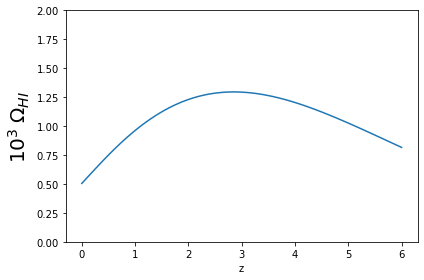

In [8]:
z=np.linspace(0,6,100,endpoint=True)
plt.figure()
plt.plot(z,1000*Omega_HI(z,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h))
plt.xlabel('z')
plt.ylabel(r'$10^3 \; \Omega_{HI}$',fontsize=20)
ax = plt.gca()
#ax.xaxis.label.set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.yaxis.label.set_color('white')
#ax.tick_params(axis='y', colors='white')
plt.ylim([0,2])
plt.tight_layout()
plt.savefig('Presentación/Omega_HI.png',dpi=300,bbox_inches='tight')
plt.show()

Árbol de Lyman Alpha indicada la presencia de H neutro con el z.

In [9]:
def bias_HI(z,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h):
    Masa = np.logspace(1,15,500)
    potencia = np.log10(Masa[1]/Masa[0])
    dMasa = Masa*(10**potencia-1)
    Delta_c = mass_so.deltaVir(z)
    integral_1 = (1/Masa)*n(Masa, z)*M_HI(Masa,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*bias.haloBias(Masa, model = 'jing98', z = z, mdef = 'vir')*dMasa
    integral_1 = sum(integral_1)
                                 
    integral_2 = (1/Masa)*n(Masa, z)*M_HI(Masa,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*dMasa
    integral_2 = sum(integral_2)
    bias_HI = integral_1/integral_2
    return bias_HI

bias_HI = np.vectorize(bias_HI)

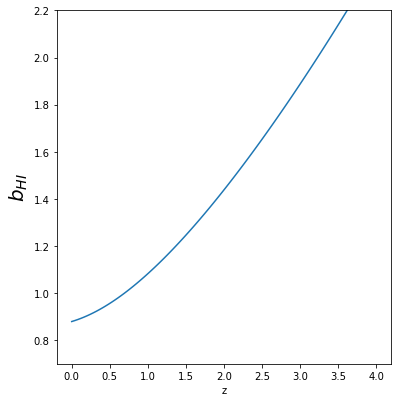

In [52]:
z=np.linspace(0,4,100,endpoint=True)
plt.figure(figsize=(6,6.5))
plt.plot(z,bias_HI(z,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h))
plt.xlabel('z')
plt.ylabel(r'$b_{HI}$',fontsize=20)
ax = plt.gca()
plt.ylim([0.7,2.2])
#ax.xaxis.label.set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.yaxis.label.set_color('white')
#ax.tick_params(axis='y', colors='white')
plt.savefig('Presentación/b_HI.png',dpi=300)
plt.show()

Sesgo de que es más probable encontrar materia ordinaria en concentraciones de materia oscura. Es más homogéneo respecto a la distribución de materia oscura que otras cosas como las galaxias rojas (galaxias viejas que sí aparecen solo en grandes regiones de materia oscura).

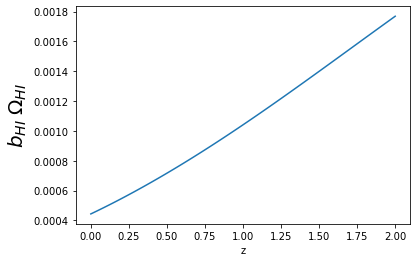

In [11]:
z=np.linspace(0,2,100,endpoint=True)
plt.figure()
plt.plot(z,bias_HI(z,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h)*Omega_HI(z,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h))
plt.xlabel('z')
plt.ylabel(r'$b_{HI} \; \Omega_{HI}$',fontsize=20)
plt.show()

### Usando las fórmulas de Coupon

En este caso se usa la variable $\nu = \frac{\delta_c(z)}{D(z) \sigma(M)}$. Por lo tanto se va a calcular la función $\sigma(M)$.

![title](sigma_M.png)

In [12]:
#nu es adimensional
def nu_function(z,M):
    D_lin = cosmo.growthFactorUnnormalized(z)
    Ez = cosmo.Ez(z)
    Omega_m0 = Omega_m
    Omega_z = (Omega_m0*(1+z)**3)*(Ez**(-2))
    rho_c = (3/20)*(12*np.pi)**(2/3)*(1 + 0.013*np.log10(Omega_z))
    nu = rho_c/(D_lin*sigma(M))
    return nu

Defino un vector de k que contenga los valores equiespaciados con un paso determinado entre ellos y calculo el espectro de potencias P(k) (a z=0) con camb. El vector de k comienza en un valor que no es cero para evitar problemas en los cálculos ya que luego se divide entre k en algún punto. Aunque tendría que ir hasta infinito, se empezó probando con un valor máximo de 1000 (se le añade la cantidad inicial infinitesimal para que así el valor del paso entre ellos pueda ser entero).

In [13]:
k = 10**np.arange(-9,2,0.02)
Pk = cosmo.matterPowerSpectrum(k)

In [14]:
Pk_interpol = sp.interpolate.interp1d(k,Pk,kind='slinear')

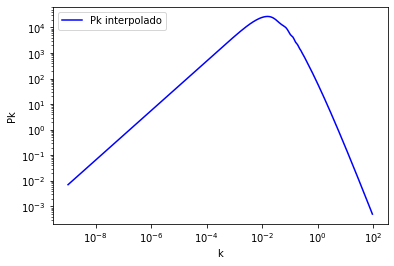

In [15]:
plt.figure()
plt.plot(k,Pk_interpol(k),'b-',label='Pk interpolado')
plt.xlabel('k')
plt.ylabel('Pk')
plt.loglog()
plt.legend()
plt.show()

Ahora, para calcular $\sigma (M)$ se integra sobre k. Para realizar la integral manualmente, creo una variable k que se va a ir aumentando en cada iteración un valor dk igual al paso definido antes. De esta manera, el i-ésimo valor de la variable k coincide con la i-ésima posición del vector P(k). 

In [16]:
def sigma_integrand(M,k):
    rho_m0 = cosmo.rho_m(0)/(1000**3)
    R = (3*M/(4*np.pi*rho_m0))**(1/3)
    x = k*R
    sigma_integrand_cuadrado = ((k**2*Pk_interpol(k))/(2*np.pi**2))*((3/x**3)*(np.sin(x)-x*np.cos(x)))**2
    sigma_integrand = np.sqrt(sigma_integrand_cuadrado)
    return sigma_integrand

In [17]:
def sigma(M):
    k = 10**np.arange(-9,2,0.02)
    dk = k*(10**0.02-1)  
    sigma = sum(sigma_integrand(M,k)*dk)                                                       
    return sigma
sigma = np.vectorize(sigma)

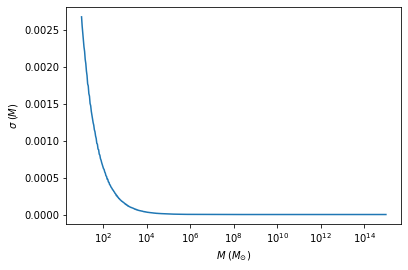

In [18]:
M = np.logspace(1,15,500)
plt.figure()
plt.plot(M,sigma(M))
plt.xscale('log')
plt.xlabel(r'$M \; (M_{\odot})$')
plt.ylabel(r'$\sigma \; (M)$')
plt.show()

Para D(z) se usa la función de colossus cosmo.growthFactorUnnormalized(z). Para $\delta_c(z)$ se usa la fórmula definida en el paper.

![title](rho_c.png)

Ahora se define la función $f(\nu)$. Para ello se usa la indicada en el paper y su condición de normalización a 1 para obtener el valor de A.

![title](f_nu.png)

Como se dice que la integral sobre las masas es entre esos valores $M_{max}$  $M_{min}$, primero se usó la fórmula $\nu = \frac{\delta_c(z)}{D(z) \sigma(M)}$ sustituyendo cada valor de la masa para obtener las $\nu_{max}$ y $\nu_{min}$ y se calculó la integral normalizada para obtener el valor de A y la función $f(\nu)$ completa. Sin embargo, estos valores de $\nu$ eran muy grandes y la exp de la función f($\nu$) anulaba la función completamente. Por lo tanto se evalúa los valores en función de $\nu$ para ver dónde no se anula.

In [19]:
def f_entre_A(nu):
    a = 1/np.sqrt(2)
    p = 0.3 
    f = (1/nu)*np.sqrt(2*a*nu**2/np.pi)*(1+(a*nu**2)**(-p))*np.e**(-a*nu**2/2)
    return f
f_entre_A = np.vectorize(f_entre_A)

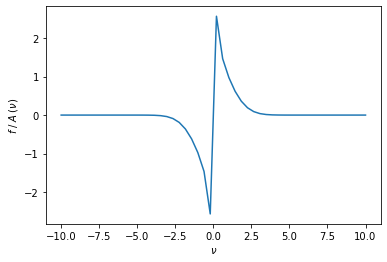

In [20]:
a = 1/np.sqrt(2)
p = 0.3
nu = np.linspace(-10,10,50)
plt.plot(nu,f_entre_A(nu))
plt.xlabel(r'$\nu$')
plt.ylabel(r'$f \; / \; A \; (\nu)$')
plt.show()

Realizamos una comprobación a ver cuánto valo en $\nu$ = 10 y -10.

In [21]:
print(-10,f_entre_A(-10))
print(10,f_entre_A(10))

-10 -3.791633829274169e-16
10 3.791633829274169e-16


Se puede ignorar ese valor.

In [22]:
nu = np.linspace(0.001,10,100)
dnu = nu[1]-nu[0]
A = 1/(sum(f_entre_A(nu))*dnu)
A = abs(A)
print(A)

0.1370580953368473


Si salto el 0 al integrar, A da negativo y por lo tanto f($\nu$) será negativa para $\nu$ > 0, que son los valores que van a tomar con la masa positiva. Es decir, no puede ser porque la densidad daría negativa también.

In [23]:
def f(nu):
    f = (1/nu)*A*np.sqrt(2*a*nu**2/np.pi)*(1+(a*nu**2)**(-p))*np.e**(-a*nu**2/2)
    return f
f = np.vectorize(f)

Para calcular la $\Omega_{HI}$ se hacía 

![title](Omega_HI.png)

Ahora podemos usar la relación 

![title](n.png)

para cambiar de variable. Como se realizan iteraciones infinitesimales donde se puede asumir que en cada iteración las funciones son constantes, lo importante es su valor numérico y no de qué variable dependen. Es decir, se puede calcular la función $M_{HI}$ usando el valor de la masa. Lo importante es que el valor de la masa usado tendría que ser el equivalente al del valor de $\nu$. Sin embargo hay que recordar que la función f($\nu$) puede que tome valores no nulos solo para un rango pequeño de valores. Ahora está multiplicada por el factor de normalización, se comprueba de nuevo.

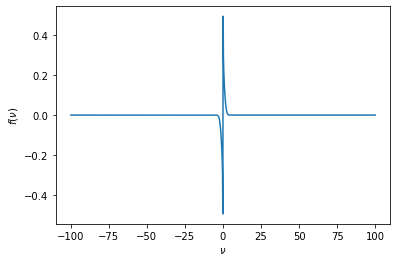

In [24]:
nu = np.linspace(-1e2,1e2,1e3)
plt.plot(nu,f(nu))
plt.xlabel(r'$\nu$')
plt.ylabel(r'$f(\nu)$')
plt.show()

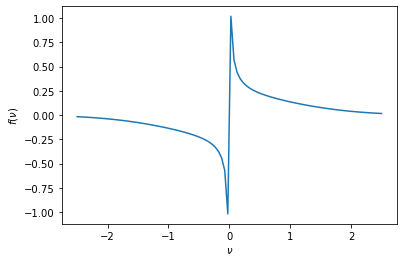

In [25]:
nu = np.linspace(-2.5,2.5,100)
plt.plot(nu,f(nu))
plt.xlabel(r'$\nu$')
plt.ylabel(r'$f(\nu)$')
plt.show()

Se vuelve a comprobar a $\nu$ = 10,-10.

In [26]:
print(-10,f(-10))
print(10,f(10))

-10 -5.196741108550744e-17
10 5.196741108550744e-17


Se pueden ignorar completamente

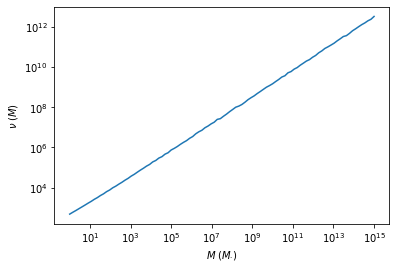

In [27]:
z = 2
M = np.logspace(0,15,100)
plt.figure()
plt.plot(M,nu_function(z,M))
plt.xlabel(r'$M \; (M_{\cdot})$')
plt.ylabel(r'$\nu \; (M)$')
plt.loglog()
plt.show()

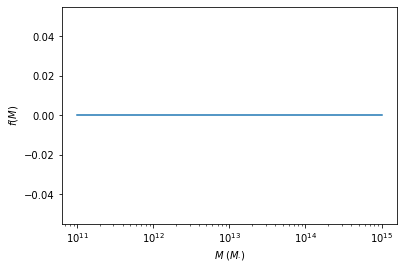

In [28]:
z = 1
M = np.logspace(11,15,100)
nu = nu_function(z,M)
plt.plot(M,f(nu))
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$M \; (M_{\cdot})$')
plt.ylabel(r'$f(M)$')
plt.show()

In [29]:
#unidades h**3 /Mpc**3 
def n_Coupon(M,z):
    nu = nu_function(z,M)
    return cosmo.rho_m(0)*f(nu)*(1/M)*(1/h)*1000**3

In [30]:
nu = nu_function(1,0.00001)
print(nu)

2.13024476717413


Desde la masa inicial de 10*0 = 1, $\nu$ toma ese valor, que ya es mayor que cero.

In [31]:
f1 = f(nu)
print(f1)

0.03151296053205833


f($\nu$ = 0.05) = 7306106348599452.0

D:\Anaconda\lib\site-packages\ipykernel\pylab\backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


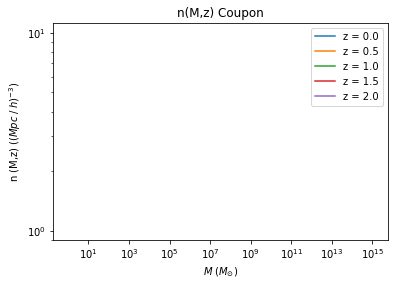

In [32]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M \; (M_{\odot})$')
plt.ylabel(r'n (M,z) (${(Mpc \; / \; h)}^{-3}$)')
plt.title('n(M,z) Coupon')
redshift = np.linspace(0.00001,2,5)
M = np.logspace(0,15,100)
for z in redshift:
    plt.plot(M,n_Coupon(M,z),label='z = {:.1f}'.format(z))
    plt.legend()
plt.show()

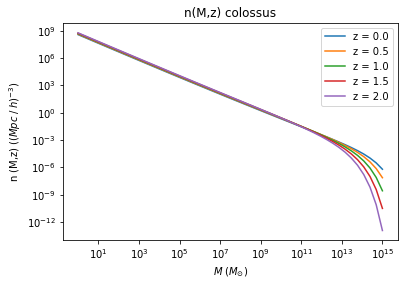

In [33]:
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M \; (M_{\odot})$')
plt.ylabel(r'n (M,z) (${(Mpc \; / \; h)}^{-3}$)')
plt.title('n(M,z) colossus')
redshift = np.linspace(0,2,5)
Masa = np.logspace(0,15)
for z in redshift:
    plt.plot(Masa,n(Masa, z),label='z = {:.1f}'.format(z))
    plt.legend()
plt.show()

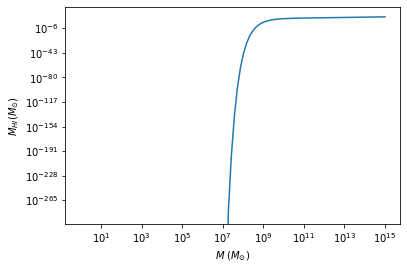

In [34]:
z = 1
M = np.logspace(0,15,100)
Delta_c = mass_so.deltaVir(z)
plt.figure()
plt.plot(M,M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M \; (M_{\odot})$')
plt.ylabel(r'$M_{HI} (M_{\odot})$')
plt.show()

In [35]:
#adimensional
def Omega_HI_integrand(z,M):
    Delta_c = mass_so.deltaVir(z)
    integrando = (1/cosmo.rho_c(0))*M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*n_Coupon(M,z)*h*(1/1000**3)
    return integrando 
Omega_HI_integrand = np.vectorize(Omega_HI_integrand)

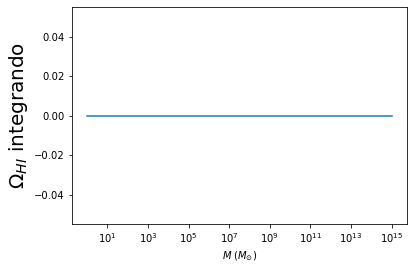

In [36]:
z = 1
M = np.logspace(0,15,100)
plt.figure()
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$M \; (M_{\odot})$')
plt.ylabel(r'$\Omega_{HI}$ integrando',fontsize=20)
plt.plot(M,Omega_HI_integrand(z,M))
plt.show()

In [37]:
#dimensional
def Omega_HI(z):
    Delta_c = mass_so.deltaVir(z)
    M = np.logspace(1,15,100)
    nu = nu_function(z,M)
    dnu = []
    for i in range(len(nu)-1):      
        dnu_scalar = nu[i+1]-nu[i]
        dnu.append(dnu_scalar)
    dnu = np.array(dnu)
    M = np.delete(M, -1)
    nu = np.delete(nu,-1)
    Omega_HI = sum(Omega_HI_integrand(z,M)*dnu)
    return Omega_HI #revisar las unidades
Omega_HI = np.vectorize(Omega_HI)

#### Unidades
$\nu$ tiene las unidades de $\delta_c$ (adim)
Creo que f($\nu$) es adimensional. Por lo tanto n(M,z) tiene las unidades de $\rho_0$/M = $h^2$/$kpc^3$

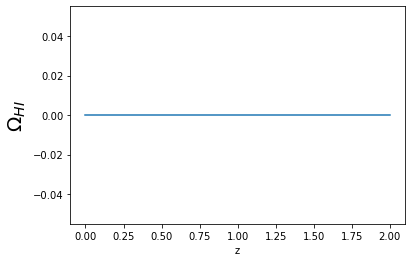

In [38]:
z=np.linspace(0,2,100,endpoint=True)
plt.figure()
plt.plot(z,Omega_HI(z))
plt.xlabel('z')
plt.ylabel(r'$\Omega_{HI}$',fontsize=20)
plt.show()

Parece que el integrando da cero porque cuando n(M,z) tiene un valor significativo, $M_{HI}$ deja de tenerlo y vice versa (se cancelan). 

### Halo bias

In [39]:
def b_integrand(M,z):   
    nu = nu_function(z,M)
    a = 1/np.sqrt(2)
    b = 0.35
    c = 0.8
    Ez = cosmo.Ez(z)
    Omega_m0 = Omega_m
    Omega_z = (Omega_m0*(1+z)**3)*(Ez**(-2))
    rho_c = (3/20)*(12*np.pi)**(2/3)*(1 + 0.013*np.log10(Omega_z))
    b_integrand = 1 + (1/(np.sqrt(a)*rho_c))*(np.sqrt(a)*(a*nu**2)+np.sqrt(a)*b*(a*nu**2)**(1-c)-(a*nu**2)**c/((a*nu**2)**c+b*(1-c)*(1-c/2)))
    return b_integrand

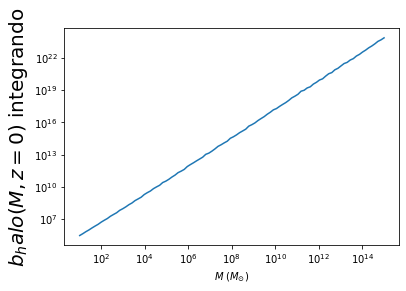

In [40]:
z = 0
M = np.logspace(1,15,100) 
plt.figure()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M \; (M_{\odot})$')
plt.ylabel(r'$b_halo (M,z=0)$ integrando',fontsize=20)
plt.plot(M,b_integrand(M,z))
plt.show()


In [41]:
def b_halo(z):
    M = np.logspace(1,15,500)
    potencia = np.log10(Masa[1]/Masa[0])
    dM = M*(10**potencia - 1)
    b_halo = sum((1/M)*b_integrand(M,z)*dM)
    return b_halo
b_halo = np.vectorize(b_halo)

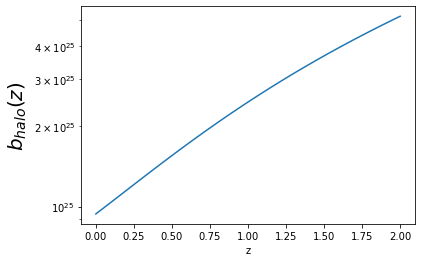

In [42]:
z = np.linspace(0,2,100)
plt.figure()
plt.yscale('log')
plt.xlabel('z')
plt.ylabel(r'$b_{halo}(z)$',fontsize=20)
plt.plot(z,b_halo(z))
plt.show()

In [43]:
#def b(z):
    #M = np.logspace(1,15,100)
    #nu = nu_function(z,M)
    #b_integrand(nu,z)
    #dnu = []
    #for i in range(len(nu)-1):      
        #dnu_scalar = nu[i+1]-nu[i]
        #dnu.append(dnu_scalar)
    #dnu = np.array(dnu)
    #M = np.delete(M, -1)
    #nu = np.delete(nu,-1)
    #Delta_c = mass_so.deltaVir(z)
    #Integral1 = sum(M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*b_integrand(nu,z)*n_Coupon(M,z)*dnu)
    #Integral2 = sum(M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*n_Coupon(M,z)*dnu)
    #b = Integral1/Integral2
    #return b
#b = np.vectorize(b)

In [44]:
def b(z):
    M = np.logspace(1,15,100)
    potencia = np.log10(M[1]/M[0])
    dM = M*(10**potencia-1)
    dM = dM.tolist()
    dM = dM.pop(-1)
    dM = np.array(dM)
    sigma_ = sigma(M)
    sigma_ = sigma_.tolist()
    sigma_ = sigma_.pop(-1)
    sigma_ = np.array(sigma_)

    D_lin = cosmo.growthFactorUnnormalized(z)
    Ez = cosmo.Ez(z)
    Omega_m0 = Omega_m
    Omega_z = (Omega_m0*(1+z)**3)*(Ez**(-2))
    rho_c = (3/20)*(12*np.pi)**(2/3)*(1 + 0.013*np.log10(Omega_z))
    
    nu = nu_function(z,M)
    dnu = -(rho_c/(D_lin*(sigma_**2)))*(np.diff(sigma(M))/np.diff(M))*dM
    
    Delta_c = mass_so.deltaVir(z)
    
    M = M.tolist()
    M = M.pop(-1)
    M = np.array(M)
    nu = nu.tolist()
    nu = nu.pop(-1)
    nu = np.array(nu)
    Integral1 = sum(M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*b_integrand(nu,z)*n_Coupon(M,z)*dnu)
    Integral2 = sum(M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c)*n_Coupon(M,z)*dnu)
    b = Integral1/Integral2
    return b
b = np.vectorize(b)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
D:\Anaconda\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


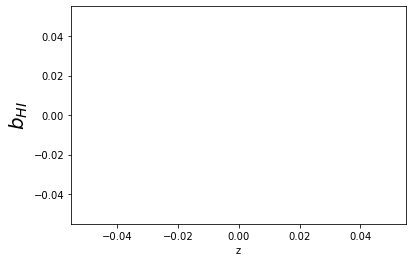

In [45]:
z=np.linspace(0,2,100,endpoint=True)

plt.figure()
plt.plot(z,b(z))
plt.xlabel('z')
plt.ylabel(r'$b_{HI}$',fontsize=20)
plt.show()